In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from urllib.request import urlopen
from zipfile import ZipFile

from IPython import display


URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/items.zip'

url = urlopen(URL)
output = open('items.zip','wb')
output.write(url.read())
output.close()


zip_ref = ZipFile('items.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation, SpatialDropout2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

import os

files = os.listdir('./dataset/items')
for name in files:
    print(name)

items_image.npy
items_label.npy


Using TensorFlow backend.


In [0]:
x1_raw = np.load('./dataset/items/items_image.npy')
y1_raw = np.load('./dataset/items/items_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

# Generate labels

unique = []
for lbl in y1_raw:
  if not lbl in unique:
    print(lbl)
    unique.append(lbl)
    
y1_coded = {}

for lbl in y1_raw:
  y1_coded[lbl] = unique.index(lbl)
  

filterLbls = [
    #'items_tools_broken',
    #'items_tools_close-weapon',
    #'items_tools_farming-crafting',
    #'items_tools_keys',
    #'items_tools_misc',
    #'items_tools_projectile',
    #'items_tools_ranged-weapon',
    #'items_tools_rod',
    #'items_tools_scepter',
    'items_tools_shields',
    #'items_tools_staff',
    #'items_tools_wands'
  ]

y1_train = []
firstTime = True

for i in range(y1_raw.shape[0]):
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_coded[y1_raw[i]])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)

    

y1_train = np.array(y1_train)

items_knowledge_book
items_knowledge_book_artefact
items_wearable_jewlery_ring
items_resources_potion
items_knowledge_cards
items_knowledge_glyphs
items_knowledge_runes
items_knowledge_scroll
items_resources_common
items_resources_crafted
items_resources_food
items_resources_gems
items_resources_metals
items_resources_organic
items_tools_broken
items_tools_close-weapon
items_tools_farming-crafting
items_tools_keys
items_tools_misc
items_tools_projectile
items_tools_ranged-weapon
items_tools_rod
items_tools_scepter
items_tools_shields
items_tools_staff
items_tools_wands
items_wearable
items_wearable_bardings
items_wearable_belt
items_wearable_cloak
items_wearable_feet
items_wearable_hands
items_wearable_headgear
items_wearable_jewlery
items_wearable_jewlery_amulet_artefact
items_wearable_jewlery_amulet
items_wearable_jewlery_ring_artefact
items_wearable_robe_n_tunic
items_wearable_torso


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  featurewise_center = True,
  featurewise_std_normalization = True,
  rotation_range = 60,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2
)

datagen.fit(x1_train)


(train_images, train_labels) = (x1_train, filterLbls)


BUFFER_SIZE = 64
BATCH_SIZE = 16


train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512*4*4, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 4)
  
    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [0]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(2e-4)
discriminator_optimizer = tf.train.AdamOptimizer(2e-4)

In [0]:
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

random_vector_for_generation = tf.random_normal([num_examples_to_generate,noise_dim])

In [0]:
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random_normal([num_examples_to_generate,noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [0]:
train_step = tf.contrib.eager.defun(train_step)

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      train_step(images)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(9,9))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img=predictions[i, :, :,:]
      img=np.array((img - np.min(img)) / (np.max(img) - np.min(img)))
      plt.imshow(img)
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

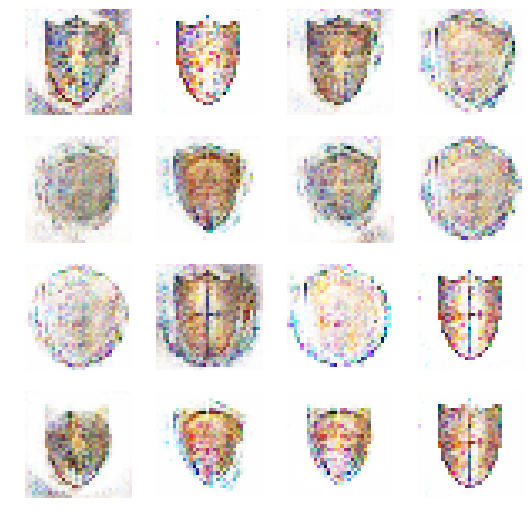

Time taken for epoch 1339 is 2.4791152477264404 sec


In [0]:
%%time
train(train_dataset, EPOCHS)